In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn import metrics, model_selection, svm
from sklearn.naive_bayes import GaussianNB
import warnings

# Init_Settings
warnings.filterwarnings("ignore")
plotting = True

In [2]:
# Read data
data = pd.read_csv('../Data/data_0802.csv', encoding='utf-8')
data = data.drop(data.columns[0], axis=1)
X_columns = [c for c in data.columns if c != '已填寫問卷數量']

# Y Transformation & X Pre-process
Y_data = data['已填寫問卷數量'].map(lambda x: 0  if int(x) == 1 else 1)
X_data = data[X_columns]
scaler = MinMaxScaler() # StandardScaler()
X_data_scaled = pd.DataFrame(scaler.fit_transform(X_data), columns=X_data.columns)

In [3]:
# Grid Search
param_grid = {
    'alpha': [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    'l1_ratio': [0.1, 0.5, 0.8, 0.9, 1]
} 

elastic_net = ElasticNet()
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5)
grid_search.fit(X_data_scaled, Y_data)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


# Elastic Net model for feature selection
enet = ElasticNet(alpha=grid_search.best_params_['alpha'], l1_ratio=grid_search.best_params_['l1_ratio'], random_state=42)
enet.fit(X_data_scaled, Y_data)

# Get selected features based on non-zero coefficients
selected_features = X_data_scaled.columns[enet.coef_ != 0].tolist()
X_enet = X_data_scaled[selected_features]
print(f"Selected {len(selected_features)} features: {selected_features}")

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Best Score: -0.0010844841686586727
Selected 59 features: ['年齡區間.x', '教育階段.x', '性別.x', '婚姻狀態', 'X36', 'X48', 'X53', 'X54', 'X4', 'X5', 'X9', 'X14', 'X56', '城市_2', '城市_4', '城市_7', '城市_8', '城市_12', '城市_13', '城市_14', '城市_15', '城市_17', '城市_19', '政治傾向_3', '政治傾向_4', '政治傾向_7', '政治傾向_9', '政治傾向_10', '籍貫_1', '籍貫_6', '職業.x_1', '職業.x_5', '職業.x_6', '職業.x_8', '職業.x_10', '職業.x_12', 'X28.1_1', 'X28.1_2', 'X28.1_3', 'X28.1_5', 'X28.1_99', 'X30_1', 'X30_2', 'X30_5', 'X30_6', 'X30_7', 'X12_2', 'X12_5', 'X64_5', 'X65_2', 'X65_3', 'X65_7', 'X66_2', 'X66_5', '主要使用聯絡方式_2', '主要使用聯絡方式_3', '主要使用聯絡方式_7', '主要使用聯絡方式_8', '主要使用聯絡方式_9']


In [7]:
# Select K
K = 'all'  
selector = SelectKBest(chi2, k=K)
X_selected = pd.DataFrame(selector.fit_transform(X_enet, Y_data), columns=X_enet.columns)
# selected_feature_names = X_selected.columns[selector.get_support()] # print(selected_feature_names)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y_data, test_size=0.2, random_state=42)
y_train, y_test = y_train.tolist(), y_test.tolist()


# Calculate the confusion matrix
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    return y_scores, acc, cm


# Random Forest Classification, LogisticRegression, SVM
model_name_list = ['Random Forest', 'Logistic Regression', 'Support Vector Machine', 'Gaussian NB', 'XGB', 'Soft Voting', 'Stacking']
model_list = [RandomForestClassifier(n_estimators=100, random_state=42),  
              LogisticRegression(solver="liblinear", random_state=42), 
              svm.SVC(probability=True, random_state=42),
              GaussianNB()]

# XGB
model_xgb = xgb.XGBClassifier(random_state=42)
param_grid = {
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
    'learning_rate': [0.5, 0.1, 0.01],
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [3, 5, 6, 7],
}

# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search_xgb.best_params_
best_xgb_model = grid_search_xgb.best_estimator_
model_list.append(best_xgb_model)
# print(f"Best Hyperparameters of XGB Model: {best_params}")



# Ensemble voting with Soft voting
clf1 = LogisticRegression(solver="liblinear", random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = svm.SVC(probability=True, random_state=42)
eclf_soft = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='soft')
model_list.append(eclf_soft)


# Stacking
stack_cf = StackingClassifier(estimators=[('rf', clf2), ('svm', clf3)], final_estimator=clf1, cv=5)
model_list.append(stack_cf)



# Train Model and Calculate ROC curve
fpr_list, tpr_list, roc_auc_list, acc_list = [], [], [], []
for md in model_list:
    y_scores, acc, cm = train_model(md)
    acc_list.append(acc)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

for md_name, acc in zip(model_name_list, acc_list):
    print(f'{md_name}: {round(acc, 4)}')

# Hard voting
eclf_hard = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='hard')
eclf_hard = eclf_hard.fit(X_train, y_train)
y_pred = eclf_hard.predict(X_test)
print(f'Hard voting: {accuracy_score(y_test, y_pred)}')

Random Forest: 0.7148
Logistic Regression: 0.7037
Support Vector Machine: 0.717
Gaussian NB: 0.6604
XGB: 0.6948
Soft Voting: 0.7192
Stacking: 0.7259
Hard voting: 0.7169811320754716


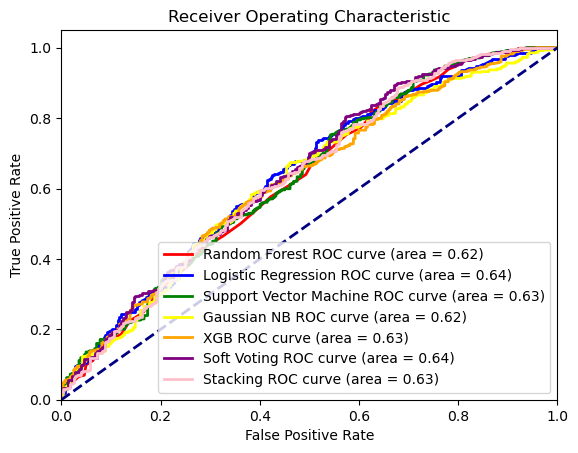

In [8]:
# Plot ROC curve
if plotting:
    plt.figure()
    color_list = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'grey']
    random_colors = [color_list[i] for i in range(len(model_name_list))]
    for fpr, tpr, roc_auc, model_name, col in zip(fpr_list, tpr_list, roc_auc_list, model_name_list, random_colors):
        plt.plot(fpr, tpr, color=col, lw=2, label=f'{model_name} ROC curve (area = {round(roc_auc, 2)})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Cross Validation Score
Random Forest, 0.7249, 0.0128
Logistic Regression, 0.7075, 0.0133
Support Vector Machine, 0.7161, 0.0083
Gaussian NB, 0.6625, 0.016
XGB, 0.7143, 0.0101
Soft Voting, 0.722, 0.0096
Stacking, 0.7211, 0.0106
Hard Voting, 0.7168, 0.0099


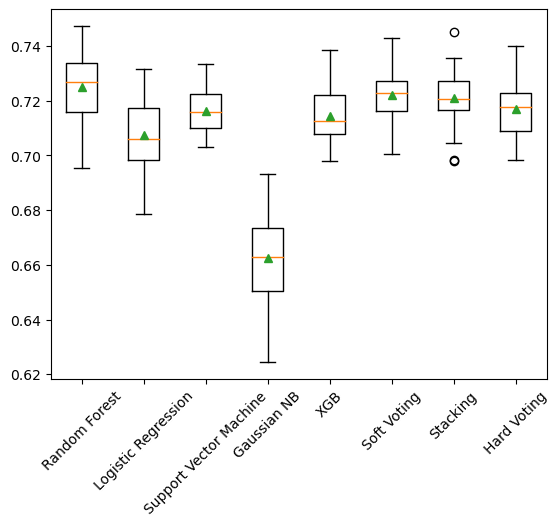

In [9]:
# Evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

model_name_list.append('Hard Voting')
model_list.append(eclf_hard)

res = []
print('Cross Validation Score')
for md_name, model in zip(model_name_list, model_list):
    sc = evaluate_model(model, X_selected, Y_data)
    res.append(sc)
    print(f'{md_name}, {round(np.mean(sc), 4)}, {round(np.std(sc), 4)}')

# Plot model performance for comparison
if plotting:
    plt.boxplot(res, labels=model_name_list, showmeans=True)
    plt.xticks(rotation=45) 
    plt.show()